# Lamb's problem: Response of a half space to a source on its surface

- Time-domain, explicit scheme, Spectral elements
- 2D
- Impedance absorbing boundary conditions

After [1], Fig. 1:  
&emsp;[1] Komatitsch, D., & Vilotte, J. P. (1998). *The spectral element method: an efficient tool to simulate the seismic response of 2D and 3D geological structures.* Bulletin of the seismological society of America, 88(2), 368-392.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dolfinx import mesh, fem, default_scalar_type
from dolfinx.io import gmshio
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde     import material, boundarycondition, PDE, PDECONFIG
from elastodynamicsx.solvers import TimeStepper
from elastodynamicsx.plot    import plotter
from elastodynamicsx.utils   import spectral_element, spectral_quadrature, ParallelEvaluator

from models.model_Lamb_KomatitschVilotte_BSSA1998 import create_model

### Set up a Spectral Element Method

In [2]:
degElement, nameElement = 8, "GLL"
PDECONFIG.default_metadata = spectral_quadrature(nameElement, degElement)

cell_type = mesh.CellType.quadrilateral
specFE = spectral_element(nameElement, cell_type, degElement, (2,))

### FE domain

In [3]:
# Create a GMSH model
sizefactor = 0.5
tilt = 10  # tilt angle (degrees)
tagBdFree, tagBdInt = 1, 2
model = create_model(sizefactor=sizefactor, tilt=tilt, tagBdFree=tagBdFree, tagBdInt=tagBdInt)

# Convert the GMSH model into a DOLFINx mesh
gmsh_model_rank = 0
comm = MPI.COMM_WORLD
domain, cell_tags, facet_tags = gmshio.model_to_mesh(model, comm, gmsh_model_rank, gdim=2)

# Create the function space
V = fem.FunctionSpace(domain, specFE)


def y_surf(x):
    """
    A convenience function to obtain the 'y' coordinate of a point
    at the free surface given its absissa 'x'
    """
    Hl = 2 * sizefactor
    return Hl + np.tan(np.radians(tilt)) * x

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000141633s, CPU 0.000165s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 6.6967e-05s, CPU 6.1e-05s)
Info    : 375 nodes 416 elements


### Define a material law
isotropic elasticity

Units:
- $\rho$ in $\mathrm{g/cm}^3$
- $c_P$, $c_S$ in $\mathrm{km/s}$

In [4]:
# parameters here...
rho    = 2.2  # density
cP, cS = 3.2, 1.8475  # P- and S-wave velocities
# ... end

c11, c44 = rho * cP**2, rho * cS**2
rho      = fem.Constant(domain, default_scalar_type(rho))
mu       = fem.Constant(domain, default_scalar_type(c44))
lambda_  = fem.Constant(domain, default_scalar_type(c11 - 2 * c44))

mat = material(V, 'isotropic', rho, lambda_, mu)

### Boundary conditions
- Absorbing boundary conditions for left, right, bottom
- Boundary traction on the top interface

In [5]:
Z_N, Z_T = mat.Z_N, mat.Z_T  # P and S mechanical impedances
T_N = fem.Function(V)  # Normal traction (Neumann boundary condition)

bc_top = boundarycondition((V, facet_tags, tagBdFree), 'Neumann', T_N)
bc_int = boundarycondition((V, facet_tags, tagBdInt), 'Dashpot', Z_N, Z_T)  # Absorbing BC on the artificial boundaries

bcs = [bc_int, bc_top]

Define the space/time distribution of the source

In [6]:
# ## -> Space function
L_, Hl_ = 4, 2  # length and height (left) for full scale
X0_src = np.array([1.720 * sizefactor, y_surf(1.720 * sizefactor), 0])  # Center
W0_src = 0.2 * L_ / 50  # Width

# Gaussian function
nrm = 1 / np.sqrt(2 * np.pi * W0_src**2)  # normalize to int[src_x(x) dx]=1


def src_x(x):  # Source(x): Gaussian
    r = (x[0] - X0_src[0]) / np.cos(np.radians(tilt))
    return nrm * np.exp(-1/2 * (r / W0_src)**2, dtype=default_scalar_type)


# ## -> Time function
fc  = 14.5  # Central frequency
sig = np.sqrt(2) / (2 * np.pi * fc)  # Gaussian standard deviation
t0  = 4 * sig


def src_t(t):  # Source(t): Ricker
    return (1 - ((t - t0) / sig)**2) * np.exp(-0.5 * ((t - t0) / sig)**2)


# ## -> Space-Time function
p0 = 1.  # Max amplitude
F_0 = p0 * default_scalar_type([np.sin(np.radians(tilt)),
                                -np.cos(np.radians(tilt))])  # Amplitude of the source


def T_N_function(t):
    return lambda x: F_0[:, np.newaxis] * src_t(t) * src_x(x)[np.newaxis, :]  # source(x) at a given time

### Assemble the PDE

In [7]:
pde = PDE(V, materials=[mat], bodyforces=[], bcs=bcs)

### Time scheme

In [8]:
# Temporal parameters
tstart = 0  # Start time
dt     = 0.25e-3  # Time step
num_steps = int(6000 * sizefactor)

cmax = ufl.sqrt((lambda_ + 2 * mu) / rho)  # max velocity
courant_number = TimeStepper.Courant_number(V.mesh, cmax, dt)  # Courant number
PETSc.Sys.Print(f'CFL condition: Courant number = {courant_number:.2f}')

#  Time integration
#     diagonal=True assumes the left hand side operator is indeed diagonal
tStepper = TimeStepper.build(V,
                             pde.m, pde.c, pde.k, pde.L, dt, bcs=bcs,
                             scheme='leapfrog', diagonal=True)

# Set the initial values
tStepper.set_initial_condition(u0=[0, 0], v0=[0, 0], t0=tstart)

CFL condition: Courant number = 0.01


### Define outputs
- Extract signals at few points
- Live-plot results (only in a terminal; not in a notebook)

In [9]:
u_res = tStepper.timescheme.u  # The solution

# -> Extract signals at few points
# Define points
xr = np.linspace(0.6, 3.4, int(100 * sizefactor)) * sizefactor
points_out = np.array([xr,
                       y_surf(xr),
                       np.zeros_like(xr)])

# Declare a convenience ParallelEvaluator
paraEval = ParallelEvaluator(domain, points_out)

# Declare data (local)
signals_local = np.zeros((paraEval.nb_points_local,
                          V.num_sub_spaces,
                          num_steps))  # <- output stored here


# -> Define callbacks: will be called at the end of each iteration
def cbck_storeAtPoints(i, out):
    if paraEval.nb_points_local > 0:
        signals_local[:, :, i+1] = u_res.eval(paraEval.points_local, paraEval.cells_local)


# -> enable live plotting
enable_plot = True
clim = 0.015 * np.linalg.norm(F_0) * np.array([0, 1])
if domain.comm.rank == 0 and enable_plot:
    kwplot = {'clim': clim, 'show_edges': False, 'warp_factor': 0.05 / np.amax(clim)}
    p = plotter(u_res, refresh_step=30, window_size=[640, 480], **kwplot)
    if paraEval.nb_points_local > 0:
        # add points to live_plotter
        p.add_points(paraEval.points_local, render_points_as_spheres=True, opacity=0.75)
else:
    p = None

### Solve
- Define a 'callfirst' function to update the load
- Run the time loop

In [10]:
# 'callfirsts': will be called at the beginning of each iteration#
def cfst_updateSources(t):
    T_N.interpolate(T_N_function(t))


# Run the big time loop!
tStepper.solve(num_steps - 1,
               callfirsts=[cfst_updateSources],
               callbacks=[cbck_storeAtPoints],
               live_plotter=p)
# End of big calc.

  0%|          | 0/2998 [00:00<?, ?it/s]

### Post-processing
- Plot signals at few points

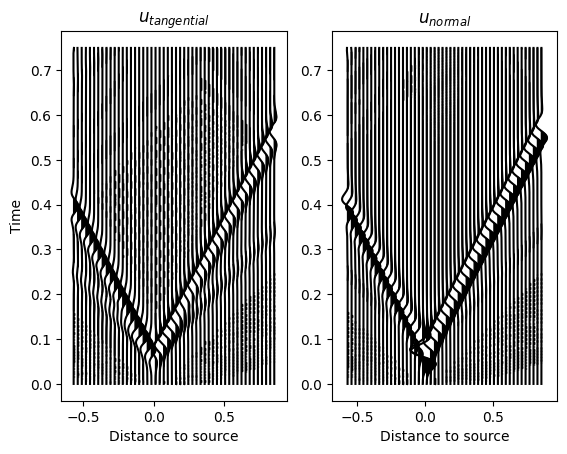

In [11]:
# Gather the data to the root process
all_signals = paraEval.gather(signals_local, root=0)

if domain.comm.rank == 0:
    t = dt * np.arange(num_steps)

    # Export as .npz file
    np.savez('seismogram_weq_2D-PSV_HalfSpace_Lamb_KomatitschVilotte_BSSA1998.npz',
             x=points_out.T, t=t, signals=all_signals)

    dx = np.linalg.norm(points_out.T[1] - points_out.T[0])
    x0 = np.linalg.norm(points_out.T[0] - X0_src)
    ampl = 4 * dx / np.amax(np.abs(all_signals))
    r11, r12 = np.cos(np.radians(tilt)), np.sin(np.radians(tilt))

    fig, ax = plt.subplots(1, 2)
    ax[0].set_title(r'$u_{tangential}$')
    ax[1].set_title(r'$u_{normal}$')
    for i in range(len(all_signals)):
        offset = i * dx - x0
        u2plt_t = offset + ampl * ( r11 * all_signals[i, 0, :] + r12 * all_signals[i, 1, :])  # tangential
        u2plt_n = offset + ampl * (-r12 * all_signals[i, 0, :] + r11 * all_signals[i, 1, :])  # normal
        ax[0].plot(u2plt_t, t, c='k')
        ax[1].plot(u2plt_n, t, c='k')
        ax[0].fill_betweenx(t, offset, u2plt_t, where=(u2plt_t > offset), color='k')
        ax[1].fill_betweenx(t, offset, u2plt_n, where=(u2plt_n > offset), color='k')
    ax[0].set_ylabel('Time')
    ax[0].set_xlabel('Distance to source')
    ax[1].set_xlabel('Distance to source')
    plt.show()

TODO: analytical formula